# Import libraries

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/TX

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/TX


In [ ]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm
import imageio

import torch
from torch.nn import functional as F
from skimage import transform, measure
from PIL import Image
import torchvision.transforms as transforms

# Functions

In [ ]:
# Function to find and load all BMP images into an array, specifically looking for folders with 'Crop_Pics_w_parameters_' and 'mbar' in their names.
def load_images_to_array_input(folder_path, categories):
    """
    Load all BMP images from the specified folders into a NumPy array.

    Args:
        folder_path (str): Path to the root folder where image categories are located.
        categories (list): List of category names (subfolders) to load images from.

    Returns:
        tuple: A tuple containing:
            - images (list): List of loaded images as NumPy arrays.
            - labels (list): List of integer labels corresponding to each image's category.
            - paths (list): List of original file paths for each image.
    """

    images = []
    labels = []
    paths = []

    category_to_idx = {cat: idx for idx, cat in enumerate(categories)}

    base_folders = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path) and "Crop_Pics_w_parameters_" in item and "mbar" in item:
            base_folders.append(item_path)

    if not base_folders:
        print("No folder found in correct format.")
        return images, labels, paths

    print(f"Found {len(base_folders)} folders:")
    for folder in base_folders:
        print(f"- {os.path.basename(folder)}")

    for base_folder in base_folders:
        print(f"Scanning the folder: {os.path.basename(base_folder)}")

        for category in categories:
            category_path = os.path.join(base_folder, category)

            if os.path.isdir(category_path):
                print(f"Found category: {category}")

                bmp_files = glob.glob(os.path.join(category_path, '**', '*.bmp'), recursive=True)

                for bmp_file in tqdm(bmp_files, desc=f"Loading {category}"):
                    img = cv2.imread(bmp_file)

                    if img is not None:
                        # Convert from BGR to RGB
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                        images.append(img_rgb)
                        labels.append(category_to_idx[category])
                        paths.append(bmp_file)

    print(f"Completed! Loaded {len(images)} images in total.")

    for category, idx in category_to_idx.items():
        count = labels.count(idx)
        print(f"  - {category}: {count} images")

    return images, labels, paths

# Function to load all BMP images from specified folders into a NumPy array.
def load_images_to_array(folder_path, categories):
    """
    Load all BMP images from the specified folders into a NumPy array.

    Args:
        folder_path (str): Path to the root folder where image categories are located.
        categories (list): Categories of images (subfolders) to load.

    Returns:
        tuple: A tuple containing:
            - images (list): List of loaded images.
            - labels (list): List of labels for each image (category).
            - paths (list): List of paths to original files.
    """

    images = []
    labels = []
    paths = []

    category_to_idx = {cat: idx for idx, cat in enumerate(categories)}

    if not os.path.exists(folder_path):
        print(f"ERROR: {folder_path} don't exist!")
        return images, labels, paths

    print(f"Folder: {folder_path}")

    print("Searching images")
    for category in categories:
        category_path = os.path.join(folder_path, category)

        if os.path.isdir(category_path):
            print(f"Found category: {category}")

            bmp_files = glob.glob(os.path.join(category_path, '**', '*.bmp'), recursive=True)

            for bmp_file in tqdm(bmp_files, desc=f"Loading {category}"):
                img = cv2.imread(bmp_file)

                if img is not None:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    images.append(img_rgb)
                    labels.append(category_to_idx[category])
                    paths.append(bmp_file)

    print(f"Completed! Loaded {len(images)} images in total.")

    for category, idx in category_to_idx.items():
        count = labels.count(idx)
        print(f"  - {category}: {count} images")

    return images, labels, paths

# Function to visualize images
def show_sample_images(images, labels, categories, num_samples=5):
    """
    View some sample images by category

    Args:
        images: List of images
        labels: List of labels
        categories: List of categories
        num_samples: Number of samples to display per category
    """

    if not images:
        print("No images to visualized")
        return

    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 3*len(categories)))

    for cat_idx, category in enumerate(categories):
        cat_indices = [i for i, label in enumerate(labels) if label == cat_idx]

        samples = min(num_samples, len(cat_indices))

        for sample_idx in range(samples):
            if len(categories) > 1:
                ax = axes[cat_idx, sample_idx]
            else:
                ax = axes[sample_idx]

            img_idx = cat_indices[sample_idx]

            ax.imshow(images[img_idx])
            ax.set_title(f"{category}")
            ax.axis('off')

        for j in range(samples, num_samples):
            if len(categories) > 1:
                axes[cat_idx, j].axis('off')
            else:
                axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Function to convert lists of images and labels into NumPy arrays
def convert_to_numpy_arrays(images, labels):
    """
    Converts lists of images and labels to NumPy arrays. Handles resizing if images have different dimensions.

    Args:
        images (list): List of images (NumPy arrays).
        labels (list): List of labels (integers or strings).

    Returns:
        tuple: A tuple containing:
            - X (np.array): NumPy array containing all images, stacked along a new axis.
            - y (np.array): NumPy array containing all labels.
    """

    if images:
        heights = [img.shape[0] for img in images]
        widths = [img.shape[1] for img in images]
        channels = [img.shape[2] for img in images]

        if len(set(heights)) > 1 or len(set(widths)) > 1 or len(set(channels)) > 1:
            print("WARNING: Images have different sizes!")
            print(f"Height: {set(heights)}")
            print(f"Width: {set(widths)}")
            print(f"Channel: {set(channels)}")

            from collections import Counter
            common_height = Counter(heights).most_common(1)[0][0]
            common_width = Counter(widths).most_common(1)[0][0]
            common_channels = Counter(channels).most_common(1)[0][0]

            print(f"Resizing all images to {common_height}x{common_width}x{common_channels}")

            resized_images = []
            for img in tqdm(images, desc="Image resizing"):
                if img.shape != (common_height, common_width, common_channels):
                    resized = cv2.resize(img, (common_width, common_height))
                    resized_images.append(resized)
                else:
                    resized_images.append(img)

            X = np.stack(resized_images, axis=0)
        else:
            X = np.stack(images, axis=0)
    else:
        X = np.array([])

    y = np.array(labels)

    return X, y


In [ ]:
def load_pretrained_unet(scale=0.5):
    """
    Load a pretrained PyTorch U-Net model from torch.hub.

    This function attempts to load the 'unet_carvana' model, which is a U-Net
    architecture specifically trained for carvana image segmentation. It also
    moves the model to GPU if available for faster processing.

    Args:
        scale (float, optional): The scale of the model to load. Defaults to 0.5.

    Returns:
        torch.nn.Module: The loaded U-Net model, or None if an error occurs.
    """
    print("Loading pretrained U-Net model from torch.hub...")
    try:
        model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=scale)
        model.eval()
        if torch.cuda.is_available():
            model = model.cuda()
            print("Model loaded on GPU")
        else:
            print("Model loaded on CPU")
        return model

    except Exception as e:
        print(f"Error loading pretrained U-Net model: {e}")
        return None

def preprocess_for_pytorch(images, target_size):
    """
    Preprocess images for input into the PyTorch U-Net model.

    This involves resizing the images to a target size and converting them
    into PyTorch tensors.

    Args:
        images (list): A list of NumPy arrays representing the images.
        target_size (tuple): A tuple (height, width) specifying the desired
                             output size for the images.

    Returns:
        tuple: A tuple containing:
            - processed_tensors (list): A list of preprocessed PyTorch tensors.
            - original_sizes (list): A list of tuples (original_height, original_width)
                                     for each image, useful for post-processing.
    """
    processed_tensors = []
    original_sizes = []

    # Define the preprocessing transform
    preprocess = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor()
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    for img in images:
        # Store original size for later
        original_sizes.append((img.shape[0], img.shape[1]))

        # Convert to PIL Image for PyTorch transforms
        pil_img = Image.fromarray(np.uint8(img * 255) if img.max() <= 1.0 else np.uint8(img))

        # Apply preprocessing
        tensor = preprocess(pil_img)
        processed_tensors.append(tensor)

    return processed_tensors, original_sizes

def segment_with_pytorch_unet(model, images, target_size, batch_size=4):
    """
    Segment cells in a batch of images using the pretrained PyTorch U-Net model.

    Images are preprocessed, fed through the U-Net model, and the output
    probability masks are returned.

    Args:
        model (torch.nn.Module): The loaded pretrained U-Net model.
        images (list): A list of NumPy arrays representing the input images.
        target_size (tuple): The target size (height, width) for image preprocessing.
        batch_size (int, optional): The number of images to process in each batch. Defaults to 4.

    Returns:
        np.array: A NumPy array containing the predicted probability masks for all images.
                  The shape will be (num_images, height, width).
    """
    print("Segmenting cells with PyTorch U-Net...")
    processed_tensors, original_sizes = preprocess_for_pytorch(images, target_size)

    masks = []

    # Process in batches
    with torch.no_grad():
        for i in range(0, len(processed_tensors), batch_size):
            batch = processed_tensors[i:i+batch_size]
            batch_tensor = torch.stack(batch)

            # Move to GPU if available
            if torch.cuda.is_available():
                batch_tensor = batch_tensor.cuda()

            # Predict masks
            outputs = model(batch_tensor)

            # Apply sigmoid to get probability masks
            probs = torch.sigmoid(outputs)

            # Move back to CPU and convert to numpy
            probs = probs.cpu().numpy()

            # Add to results
            for j in range(probs.shape[0]):
                mask = probs[j, 0]  # Get the first (and only) channel
                masks.append(mask)

    return np.array(masks)

def extract_and_crop_cells(images, labels, masks, margin=3, threshold=0.5):
"""
    Extract individual cells from segmented masks and crop them from the original images.

    This function performs post-processing on the segmentation masks to identify
    individual cells, filter out noise, and then crop these cells with a specified
    margin.

    Args:
        images (list): A list of original NumPy array images.
        labels (list): A list of labels corresponding to the original images.
        masks (np.array): A NumPy array of segmentation masks (probability maps)
                          generated by the U-Net model.
        margin (int, optional): The pixel margin to add around the detected
                                cell during cropping. Defaults to 3.
        threshold (float, optional): The threshold to binarize the probability masks.
                                     Pixels with probability below this value are
                                     considered background. Defaults to 0.5.

    Returns:
        tuple: A tuple containing:
            - cropped_cells (list): A list of NumPy arrays, each representing a
                                    cropped cell image.
            - cell_metadata (list): A list of dictionaries, each containing
                                    metadata about a cropped cell (e.g., original
                                    image index, bounding box, center, radius).
            - binary_masks (list): A list of binary masks after thresholding
                                   and morphological operations.
            - num_labels (list): A list of the number of unique labels (potential cells)
                                 found in each image's binary mask.
            - num_real_cells (list): A list of the number of "real" cells (based on pixel intensity)
                                     found and cropped from each image.
    """
    print("Extracting and cropping cells...")
    cropped_cells = []
    cell_metadata = []
    binary_masks = []
    num_labels = []
    num_real_cells = []

    for idx, (img, mask) in enumerate(zip(images, masks)):
        lab_idx = labels[idx]
        # Apply threshold to get binary mask
        binary_mask = (mask < threshold).astype(np.uint8)

        # Remove small objects and fill holes for better segmentation
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))

        binary_masks.append(binary_mask)

        # Find connected components
        labeled_mask, num_label = measure.label(binary_mask, return_num=True, connectivity=2)

        if num_label == 0:
            print(f"No cells detected in image {idx}")
            continue
        num_labels.append(num_label)

        print(f"Found {num_label} cells in image {idx}")
        num_real_cell = 0

        # Process each detected cell
        for label_idx in range(1, num_label + 1):
            # Extract single cell mask
            cell_mask = (labeled_mask == label_idx).astype(np.uint8)

            # Find cell properties
            props = measure.regionprops(cell_mask)
            if not props:
                continue

            # Get cell bounding box
            min_row, min_col, max_row, max_col = props[0].bbox

            # Check if the cell is too small (might be noise)
            cell_height = max_row - min_row
            cell_width = max_col - min_col

            if cell_height < 5 or cell_width < 5:
                continue  # Skip very small regions

            if cell_width > 60:
                continue  # Skip very large regions

            # Calculate radius of the cell (approximating as a circle)
            # Using the maximum of height/2 and width/2 to ensure we encompass the entire cell
            radius = max(cell_height, cell_width) / 2

            # Get the cell center coordinates
            center_row = (min_row + max_row) // 2
            center_col = (min_col + max_col) // 2

            # Calculate cropping boundaries with margin around the cell
            crop_min_row = max(0, center_row - radius - margin)
            crop_max_row = min(img.shape[0], center_row + radius + margin)
            crop_min_col = max(0, center_col - radius - margin)
            crop_max_col = min(img.shape[1], center_col + radius + margin)

            # Convert to integers
            crop_min_row, crop_max_row = int(crop_min_row), int(crop_max_row)
            crop_min_col, crop_max_col = int(crop_min_col), int(crop_max_col)

            # Crop the cell from original image
            cropped_cell = img[crop_min_row:crop_max_row, crop_min_col:crop_max_col].copy()

            # Make sure we actually have a cell to save
            if cropped_cell.size == 0 or cropped_cell.shape[0] == 0 or cropped_cell.shape[1] == 0:
                continue

            # Count real cells
            if cropped_cell.max() > 1:
                num_real_cell = num_real_cell + 1

            # Add to results
            cropped_cells.append(cropped_cell)

            # Store metadata about this cell
            cell_metadata.append({
                'original_image_idx': idx,
                'cell_idx': lab_idx,
                'center': (center_row, center_col),
                'radius': radius,
                'crop_coords': (crop_min_row, crop_min_col, crop_max_row, crop_max_col),
                'height': crop_max_row - crop_min_row,
                'width': crop_max_col - crop_min_col,
                'area': props[0].area
            })

        print(f"{num_real_cell} real cells found in image {idx}")
        num_real_cells.append(num_real_cell)

    return cropped_cells, cell_metadata, binary_masks, num_labels, num_real_cells

def visualize_results(original_images, masks, cropped_cells, cell_metadata, num_samples=3):
    """
    Visualize the segmentation results, including original images, binary masks,
    and a sample of cropped cells.

    Args:
        original_images (list): List of original input images.
        masks (np.array): NumPy array of segmentation masks.
        cropped_cells (list): List of cropped cell images.
        cell_metadata (list): List of dictionaries with metadata for each cropped cell.
        num_samples (int, optional): Number of sample images to display. Defaults to 3.
    """
    num_samples = min(num_samples, len(original_images))

    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(original_images[i], cmap = 'gray')
        plt.title('Mask')
        plt.axis('off')

        # Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Binary Mask')
        plt.axis('off')

        # If we have cropped cells, show the first one from this image
        cell_indices = [j for j, m in enumerate(cell_metadata) if m['original_image_idx'] == i]

        if cell_indices:
            plt.subplot(num_samples, 3, i*3 + 3)
            plt.imshow(cropped_cells[cell_indices[0]])
            plt.title(f'Cropped Cell (r={cell_metadata[cell_indices[0]]["radius"]:.1f}px)')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Also show a grid of cropped cells if we have many
    # if len(cropped_cells) > 9:
    #     plt.figure(figsize=(12, 12))
    #     for i in range(min(9, len(cropped_cells))):
    #         plt.subplot(3, 3, i+1)
    #         plt.imshow(cropped_cells[i])
    #         meta = cell_metadata[i]
    #         plt.title(f'Cell {i} ({meta["width"]}x{meta["height"]}px)')
    #         plt.axis('off')
    #     plt.tight_layout()
    #     plt.show()

def save_cropped_cells(cropped_cells, output_dir, original_labels=None, cell_metadata=None):
    """
    Save the extracted and cropped cells as image files to a specified directory.

    Cells can be organized into subdirectories based on their original labels if provided.

    Args:
        cropped_cells (list): A list of NumPy arrays, each being a cropped cell image.
        output_dir (str): The path to the directory where the cropped cells will be saved.
        original_labels (list, optional): A list of labels for the original images.
                                         If provided, cells will be saved into
                                         'class_X' subdirectories. Defaults to None.
        cell_metadata (list, optional): A list of dictionaries containing metadata
                                        for each cropped cell. Used to link cells
                                        back to their original images and labels.
                                        Defaults to None.
    """
    if len(cropped_cells) == 0:
        print("No cropped cells to save.")
        return

    os.makedirs(output_dir, exist_ok=True)

    # Create subdirectories for each category if labels are provided
    if original_labels is not None:
        label_dirs = {}
        unique_labels = np.unique(original_labels)
        for label in unique_labels:
            label_dir = os.path.join(output_dir, f"class_{label}")
            os.makedirs(label_dir, exist_ok=True)
            label_dirs[label] = label_dir

    # Save each cropped cell
    for i, cell_img in enumerate(cropped_cells):
        if cell_metadata and i < len(cell_metadata):
            metadata = cell_metadata[i]
            original_idx = metadata['original_image_idx']

            # Determine the label for this cell
            if original_labels is not None and original_idx < len(original_labels):
                label = original_labels[original_idx]
                save_path = os.path.join(label_dirs[label], f"cell_{original_idx}_{metadata['cell_idx']}.png")
            else:
                save_path = os.path.join(output_dir, f"cell_{i}.png")
        else:
            save_path = os.path.join(output_dir, f"cell_{i}.png")

        # Convert to uint8 for saving
        if cell_img.dtype == np.float32 or cell_img.dtype == np.float64:
            if cell_img.max() <= 1.0:
                cell_img_uint8 = (cell_img * 255).astype(np.uint8)
            else:
                cell_img_uint8 = cell_img.astype(np.uint8)
        else:
            cell_img_uint8 = cell_img

        # Save the image
        plt.imsave(save_path, cell_img_uint8)

    print(f"Saved {len(cropped_cells)} cropped cells to {output_dir}")

def process_cell_images_with_pytorch_unet(images, labels, target_size, scale, margin):
    """
    Main function to orchestrate the cell image processing pipeline using a
    pretrained PyTorch U-Net model.

    This function loads the model, segments cells, extracts and crops them,
    visualizes a sample of the results, and saves the cropped cells.

    Args:
        images (list): A list of original NumPy array images.
        labels (list): A list of labels corresponding to the original images.
        target_size (tuple): The target size (height, width) for image
                             preprocessing before feeding to the U-Net.
        scale (float): The scale parameter for loading the U-Net model.
        margin (int): The pixel margin to apply during cell cropping.

    Returns:
        tuple: A tuple containing:
            - cropped_cells (list): List of cropped cell images.
            - cell_metadata (list): Metadata for each cropped cell.
            - masks (np.array): Predicted segmentation masks.
            - num_fake_cells (list): Number of "fake" or discarded cells per image (from `num_labels` output).
            - num_real_cells (list): Number of "real" or kept cells per image.
    """
    # Step 1: Load pretrained PyTorch U-Net model
    model = load_pretrained_unet(scale=scale)
    #
    if model is None:
        print("Failed to load pretrained model. Exiting.")
        return None, None, None

    # Step 2: Segment cells with the model
    masks = segment_with_pytorch_unet(model, images, target_size)

    # Step 3: Extract and crop cells (with margin)
    cropped_cells, cell_metadata, binary_masks, num_fake_cells, num_real_cells = extract_and_crop_cells(images, labels, masks, margin=margin, threshold= 0.8)

    # Step 4: Visualize results
    visualize_results(masks, binary_masks, cropped_cells, cell_metadata)

    # Step 5: Save cropped cells
    output_dir = "./cropped_cells_2024"
    save_cropped_cells(cropped_cells, output_dir, labels, cell_metadata)

    return cropped_cells, cell_metadata, masks, num_fake_cells, num_real_cells


In [ ]:
def save_images_by_category(X, y, output_dir, categories):
    """
    Save the images X into corresponding category folders based on the labels y.

    This function iterates through a collection of images and their associated
    labels, then saves each image into a dedicated subdirectory named after its
    category within the specified output directory.

    Args:
        X (np.array or list): A NumPy array or list of images to be saved.
                              Each image is expected to be a NumPy array.
        y (np.array or list): A NumPy array or list of integer labels, where
                              each label corresponds to the category of the
                              respective image in X.
        output_dir (str): The path to the root directory where the category
                          folders and images will be saved.
        categories (list): A list of strings, where each string is the name
                           of a category, corresponding to the integer labels in y.
                           The index of the category name in this list should match
                           the integer label.
    """
    if len(X) == 0:
        print("No images to save.")
        return

    os.makedirs(output_dir, exist_ok=True)

    # Create a folder for each category
    category_dirs = {}
    for category in categories:
        category_dir = os.path.join(output_dir, category)
        os.makedirs(category_dir, exist_ok=True)
        category_dirs[category] = category_dir

    # Save each image into its corresponding category folder
    for idx, (img, label_idx) in enumerate(zip(X, y)):
        if label_idx >= len(categories):
            print(f"Warning: Label index {label_idx} out of range for image {idx}")
            continue
        category = categories[label_idx]

        # Convert to uint8 for saving
        if img.dtype == np.float32 or img.dtype == np.float64:
            if img.max() <= 1.0:
                cell_img_uint8 = (img * 255).astype(np.uint8)
            else:
                cell_img_uint8 = img.astype(np.uint8)
        else:
            cell_img_uint8 = img

        save_path = os.path.join(category_dirs[category], f"img_{idx}.png")

        plt.imsave(save_path, cell_img_uint8)

    print(f"Saved {len(X)} images in {output_dir}")

def report_folder_distribution(output_dir):
    """
    Report the distribution of images within subfolders of a given directory.

    This function walks through the specified output directory and its subdirectories
    to count the number of .png images in each folder, providing a summary of
    the image distribution.

    Args:
        output_dir (str): The path to the root directory to analyze.
    """
    print("\nDistribution of images in each folder:")
    for root, dirs, files in os.walk(output_dir):
        # Only print folders that contain images
        if files:
            num_images = len([f for f in files if f.endswith('.png')])
            if num_images > 0:
                folder_name = os.path.basename(root)
                print(f"{folder_name}: {num_images} images")

# 2024 study dataset

In [ ]:
folder_path_2024_study = "/gdrive/My Drive/Colab Notebooks/TX/2024_study"
categories_2024_study = ['Slipper', 'semi-Slipper', 'semi-Parachute', 'Parachute'] #,'Rolling', 'semi-Rolling']

# Load images
images_2024_study, labels_2024_study, paths_2024_study = load_images_to_array(folder_path_2024_study, categories_2024_study)
images, labels = convert_to_numpy_arrays(images_2024_study, labels_2024_study)


Folder: /gdrive/My Drive/Colab Notebooks/TX/2024_study
Searching images
Found category: Slipper


Loading Slipper: 100%|██████████| 391/391 [00:06<00:00, 61.15it/s] 


Found category: semi-Slipper


Loading semi-Slipper: 100%|██████████| 201/201 [00:04<00:00, 50.18it/s] 


Found category: semi-Parachute


Loading semi-Parachute: 100%|██████████| 311/311 [00:04<00:00, 66.29it/s] 


Found category: Parachute


Loading Parachute: 100%|██████████| 732/732 [00:13<00:00, 55.31it/s] 


Completed! Loaded 1635 images in total.
  - Slipper: 391 images
  - semi-Slipper: 201 images
  - semi-Parachute: 311 images
  - Parachute: 732 images
Height: {50, 66}
Width: {100}
Channel: {3}
Resizing all images to 50x100x3


Image resizing: 100%|██████████| 1635/1635 [00:00<00:00, 265801.82it/s]


In [ ]:
first_image = images[0]

if len(first_image.shape) == 2:
    print("The image is Grayscale (single channel).")
elif len(first_image.shape) == 3 and first_image.shape[2] == 1:
    print("The image is Grayscale but stored with an extra dimension.")
elif len(first_image.shape) == 3 and first_image.shape[2] == 3:
    print("The image is RGB (three channels).")
else:
    print("Unknown format:", first_image.shape)

first_image.shape

The image is RGB (three channels).


(50, 100, 3)

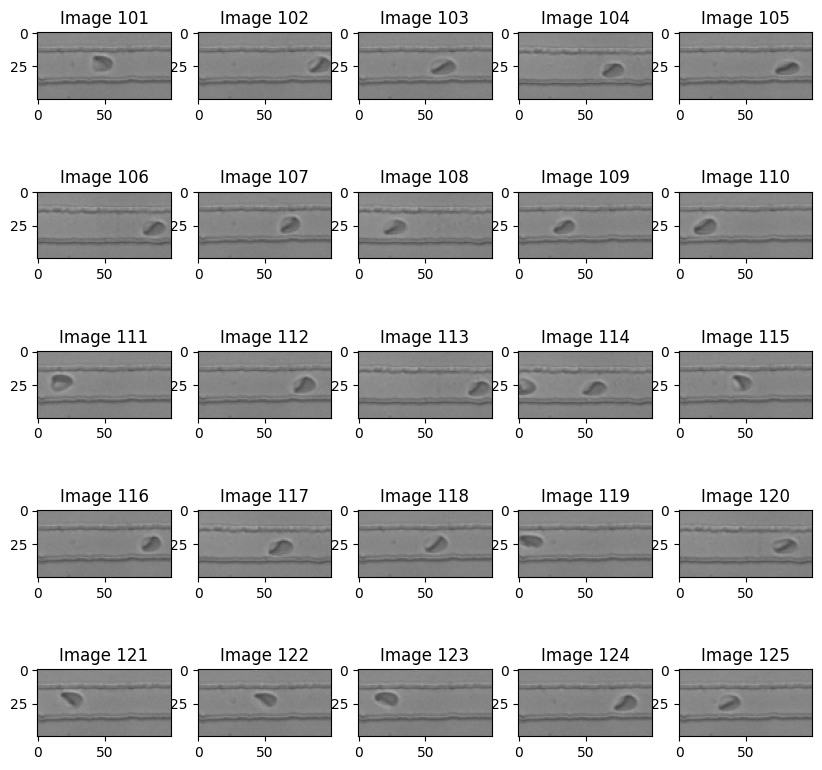

In [ ]:
# Show a range of images
img=100
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i+img])
  plt.title(f'Image {i+img+1}')
plt.show()

## Detect cell

Loading pretrained U-Net model from torch.hub...


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /root/.cache/torch/hub/checkpoints/unet_carvana_scale0.5_epoch2.pth
100%|██████████| 118M/118M [00:00<00:00, 125MB/s]


Model loaded on GPU
Segmenting cells with PyTorch U-Net...
Extracting and cropping cells...
Found 5 cells in image 0
1 real cells found in image 0
Found 4 cells in image 1
1 real cells found in image 1
Found 6 cells in image 2
2 real cells found in image 2
Found 5 cells in image 3
1 real cells found in image 3
Found 5 cells in image 4
1 real cells found in image 4
Found 4 cells in image 5
1 real cells found in image 5
Found 3 cells in image 6
0 real cells found in image 6
Found 3 cells in image 7
1 real cells found in image 7
Found 3 cells in image 8
0 real cells found in image 8
Found 4 cells in image 9
1 real cells found in image 9
Found 3 cells in image 10
0 real cells found in image 10
Found 5 cells in image 11
1 real cells found in image 11
Found 3 cells in image 12
1 real cells found in image 12
Found 4 cells in image 13
0 real cells found in image 13
Found 4 cells in image 14
1 real cells found in image 14
Found 4 cells in image 15
0 real cells found in image 15
Found 4 cells in

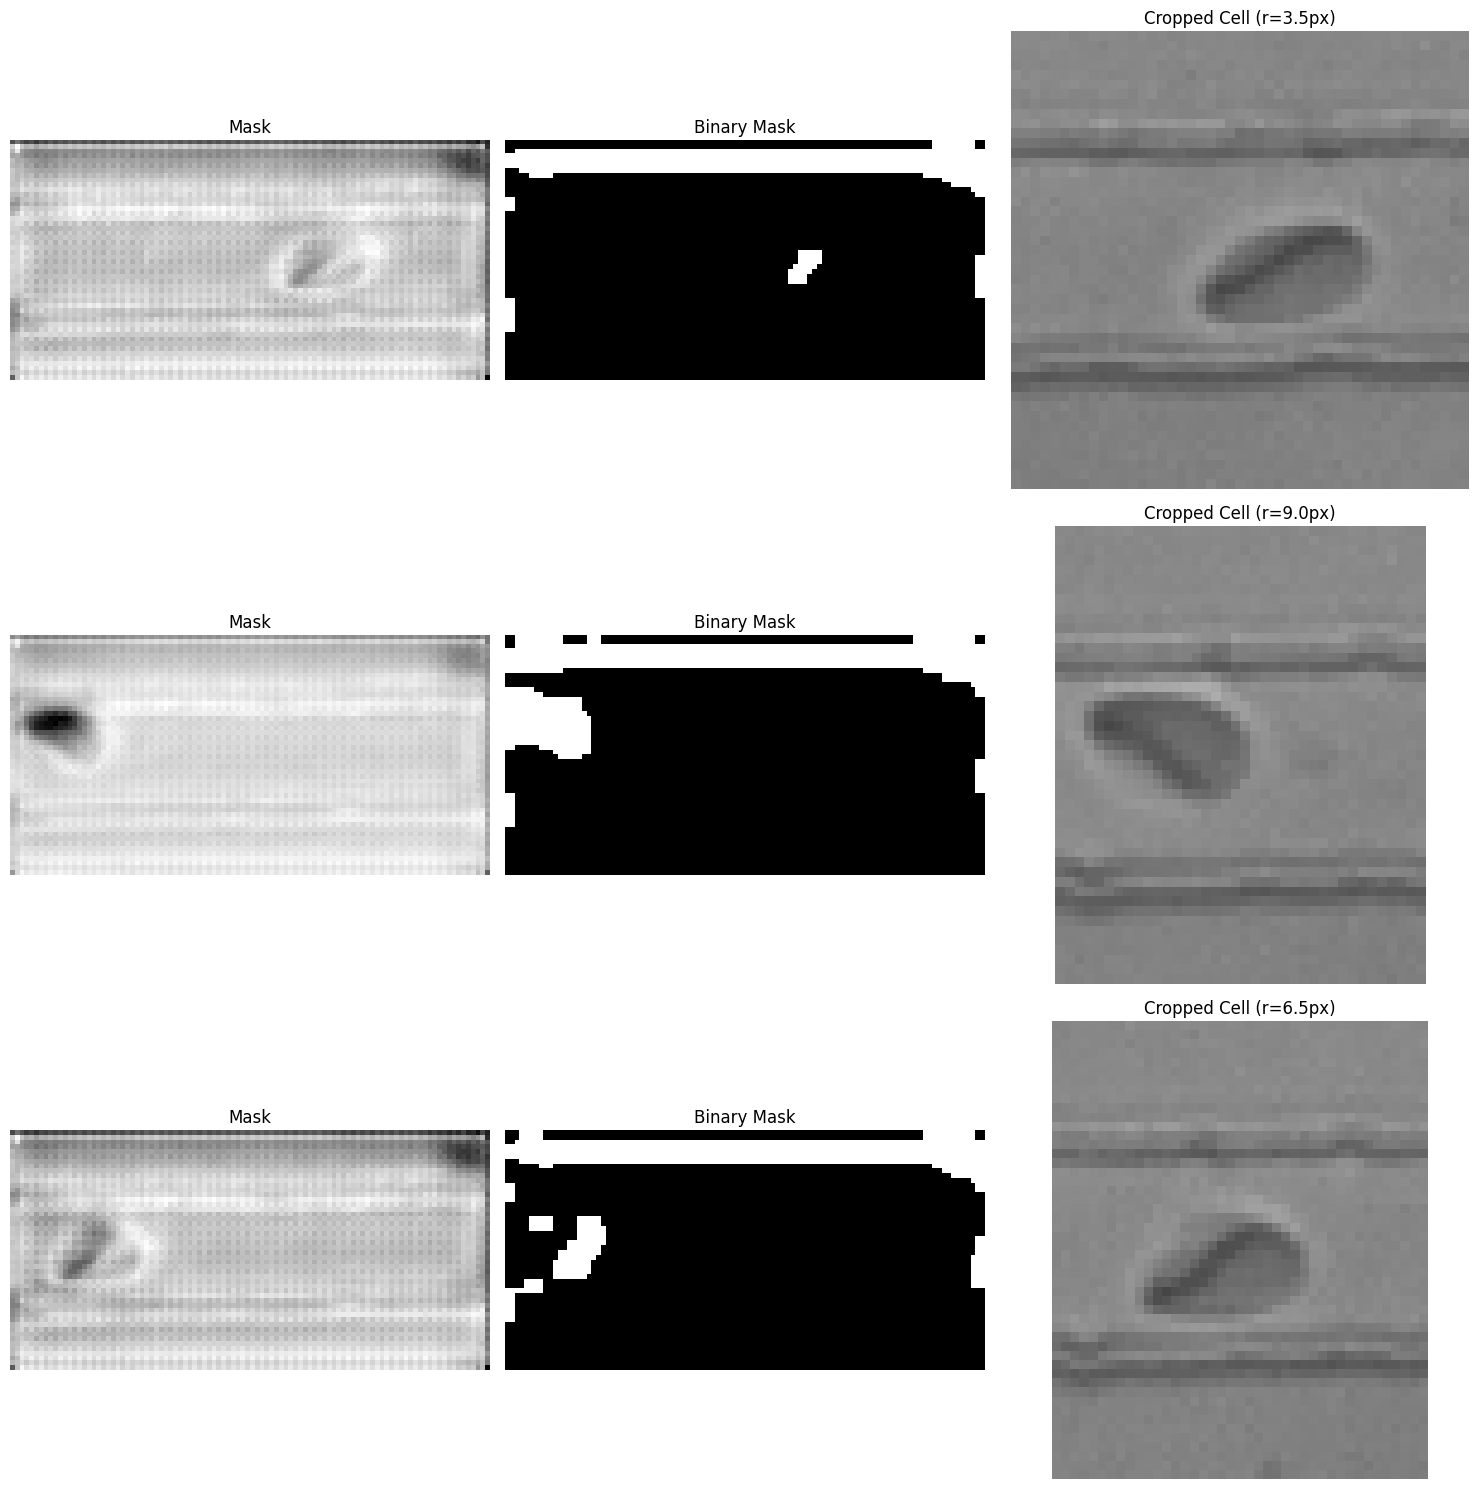

Saved 1414 cropped cells to ./cropped_cells_2024

Processing complete:
- Original images: 1635
- Categories: Slipper, semi-Slipper, semi-Parachute, Parachute
- Extracted cells: 1414
- Margin around cells: 20 pixels
- Output saved to: ./cropped_cells


In [ ]:
if len(images) > 0:
    MARGIN = 20
    # Process images with pretrained PyTorch U-Net
    cropped_cells, cell_metadata, masks, num_fake_cells, num_real_cells = process_cell_images_with_pytorch_unet(
        images, labels, target_size=(50,100), scale=0.5, margin=MARGIN
    )

    # Print summary
    print(f"\nProcessing complete:")
    print(f"- Original images: {len(images)}")
    print(f"- Categories: {', '.join(categories_2024_study)}")
    print(f"- Extracted cells: {len(cropped_cells)}")
    print(f"- Margin around cells: {MARGIN} pixels")
    print(f"- Output saved to: ./cropped_cells")
else:
    print("No images found in the specified directories.")

In [ ]:
indici_valori_non_one = [(i, val) for i, val in enumerate(num_real_cells) if val != 1]

indici = [x[0] for x in indici_valori_non_one]
valori = [x[1] for x in indici_valori_non_one]

total_index = len([val for val in num_real_cells if val != 1])
print("Total index different from one: ", total_index)
total_index_one = len([val for val in num_real_cells if val == 1])
print("Total index equal to one: ", total_index_one)
total_index_zero = len([val for val in num_real_cells if val == 0])
print("Total index equal to zero: ", total_index_zero)
total_index_two = len([val for val in num_real_cells if val == 2])
print("Total index equal to two: ", total_index_two)
total_index_three = len([val for val in num_real_cells if val == 3])
print("Total index equal to three: ", total_index_three)
total_index_four = len([val for val in num_real_cells if val == 4])
print("Total index equal to four: ", total_index_four)

Total index different from one:  483
Total index equal to one:  1152
Total index equal to zero:  355
Total index equal to two:  122
Total index equal to three:  6
Total index equal to four:  0


In [ ]:
from collections import Counter

def count_cells_per_label(cell_metadata):
    # Initialize a Counter object to count occurrences of cell_idx values
    count = Counter()

    # Loop through each cell metadata and count the occurrences of 'cell_idx'
    for meta in cell_metadata:
        cell_idx = meta['cell_idx']
        count[cell_idx] += 1

    return count


# Usage
label_counts = count_cells_per_label(cell_metadata)
print("Cell counts per label:")
for label, count in label_counts.items():
    print(f"Label {label}: {count} cells")

Cell counts per label:
Label 0: 250 cells
Label 1: 182 cells
Label 2: 290 cells
Label 3: 692 cells


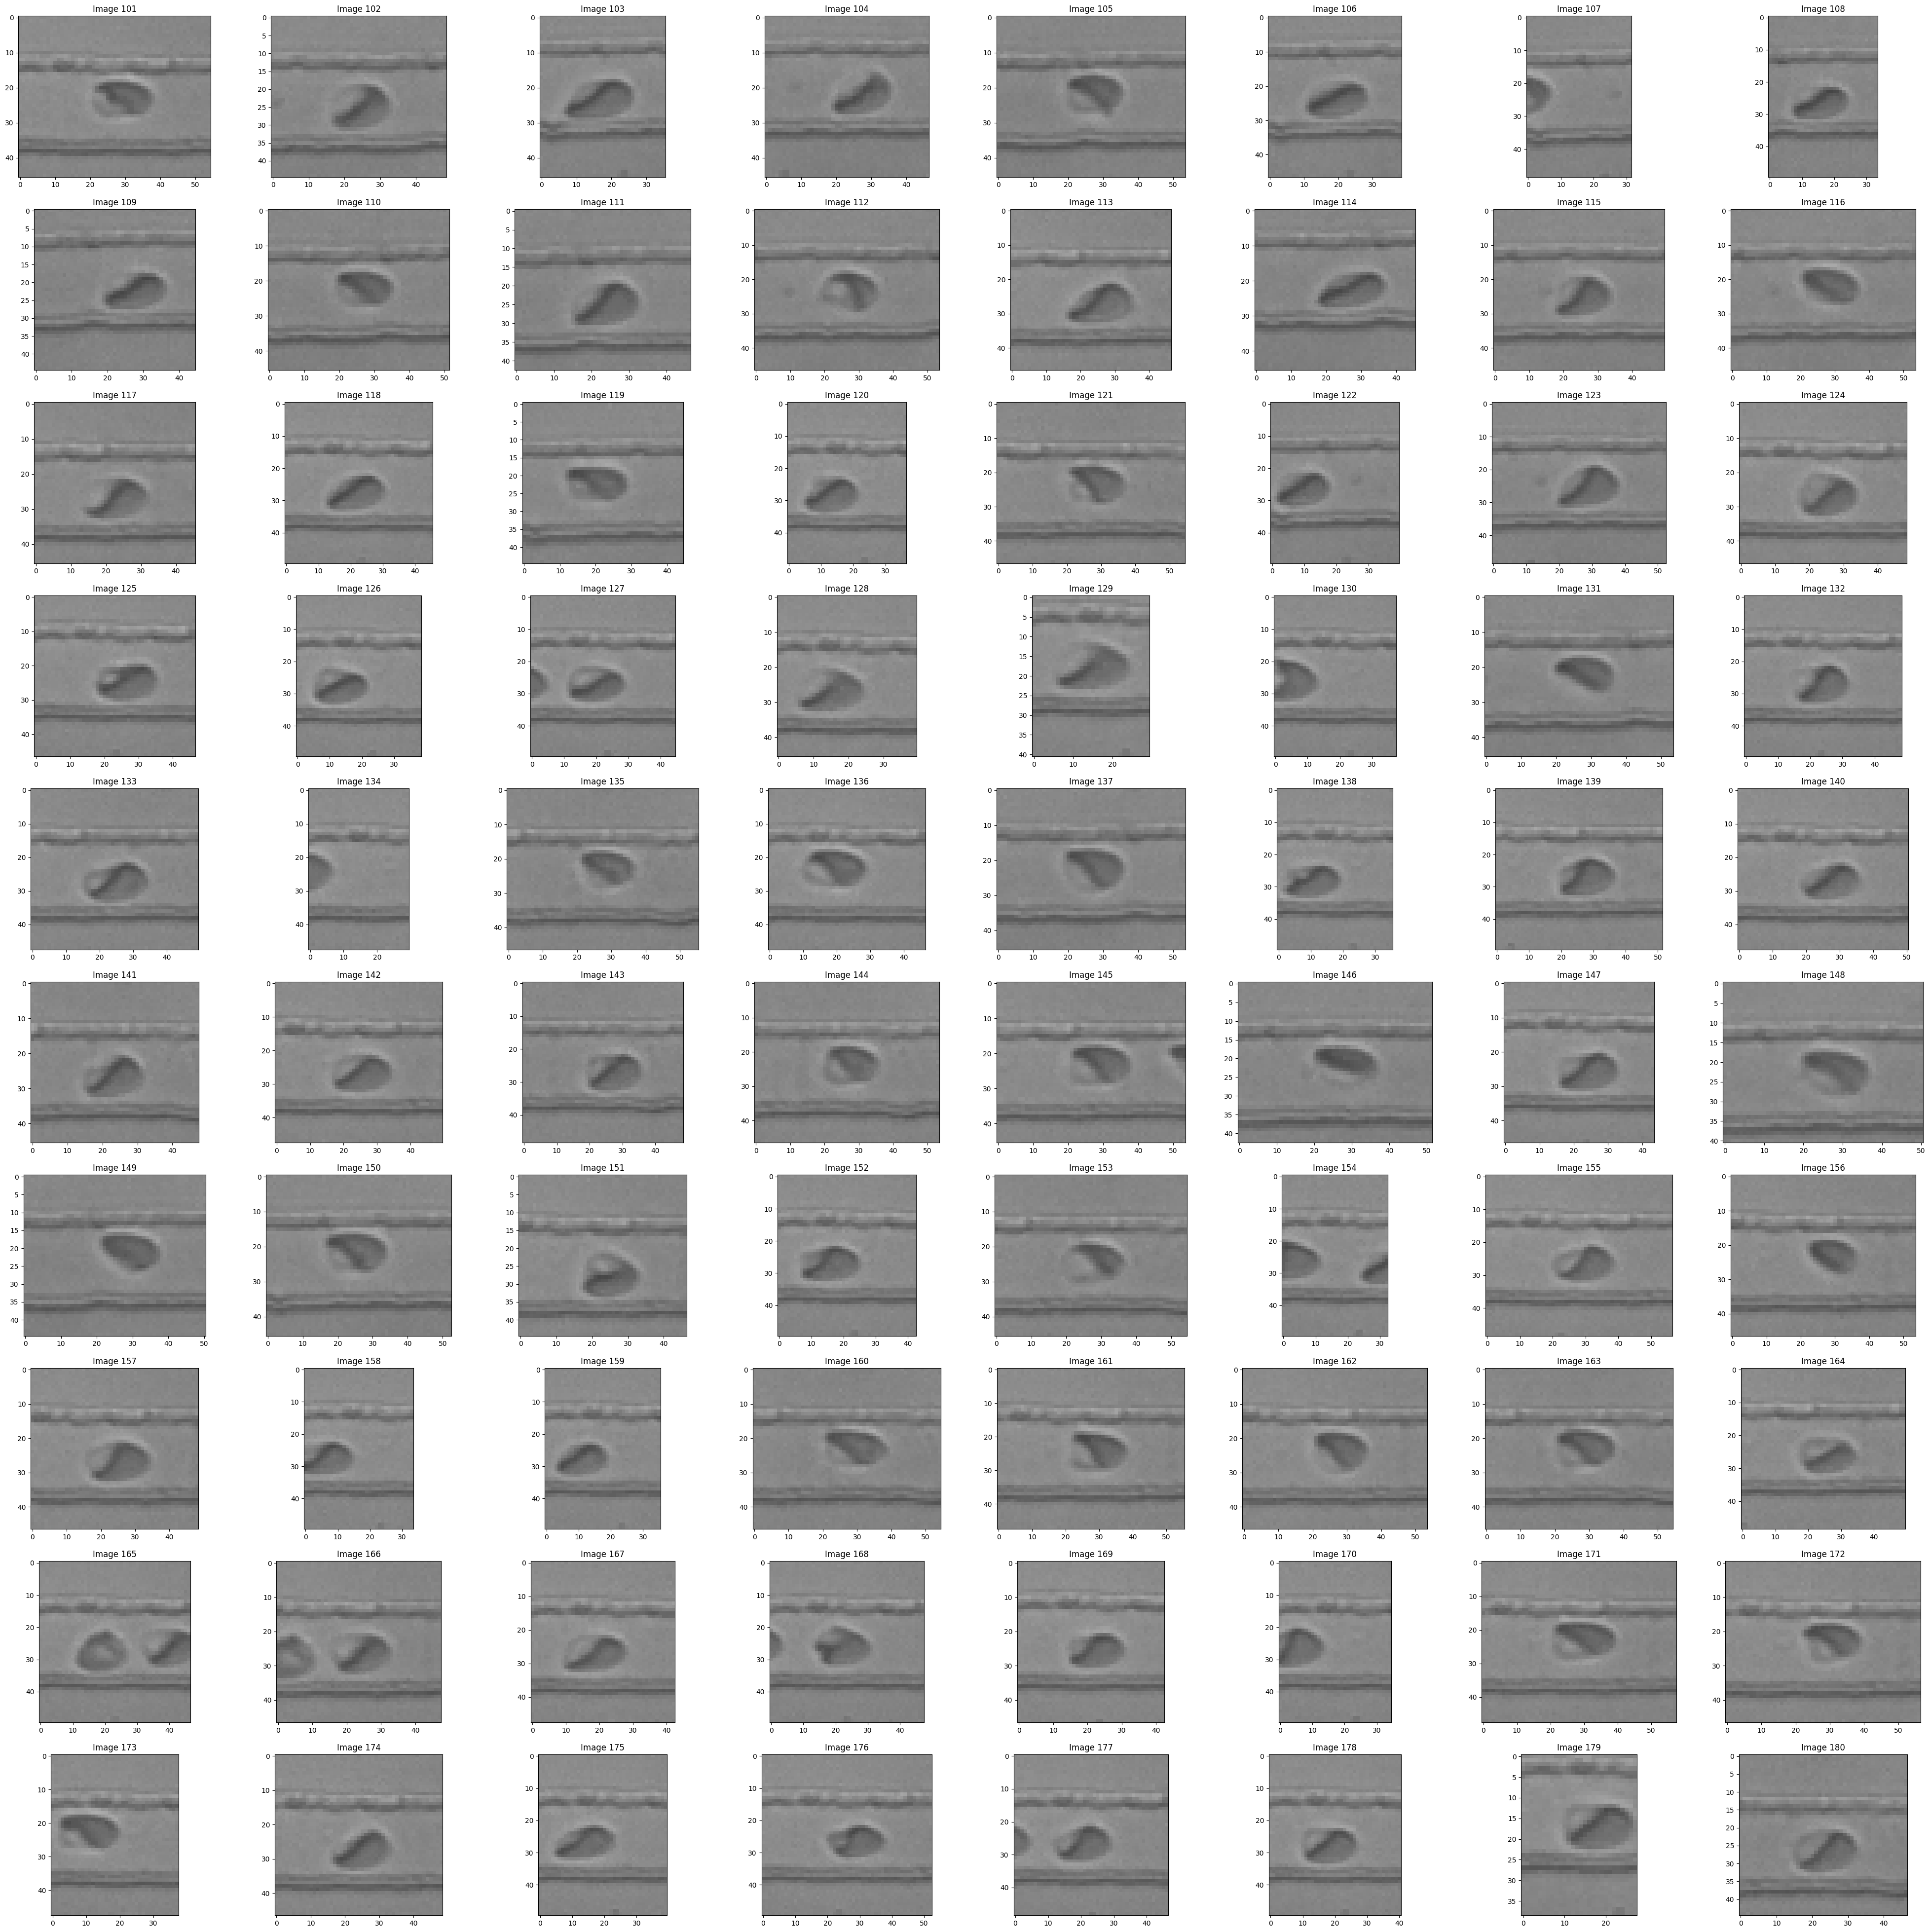

In [ ]:
# Show a range of images
img=100
plt.figure(figsize=(50, 50))
for i in range(80):
  plt.subplot(10, 8, i+1)
  plt.imshow(cropped_cells[i+img])
  plt.title(f'Image {i+img+1}')
plt.show()

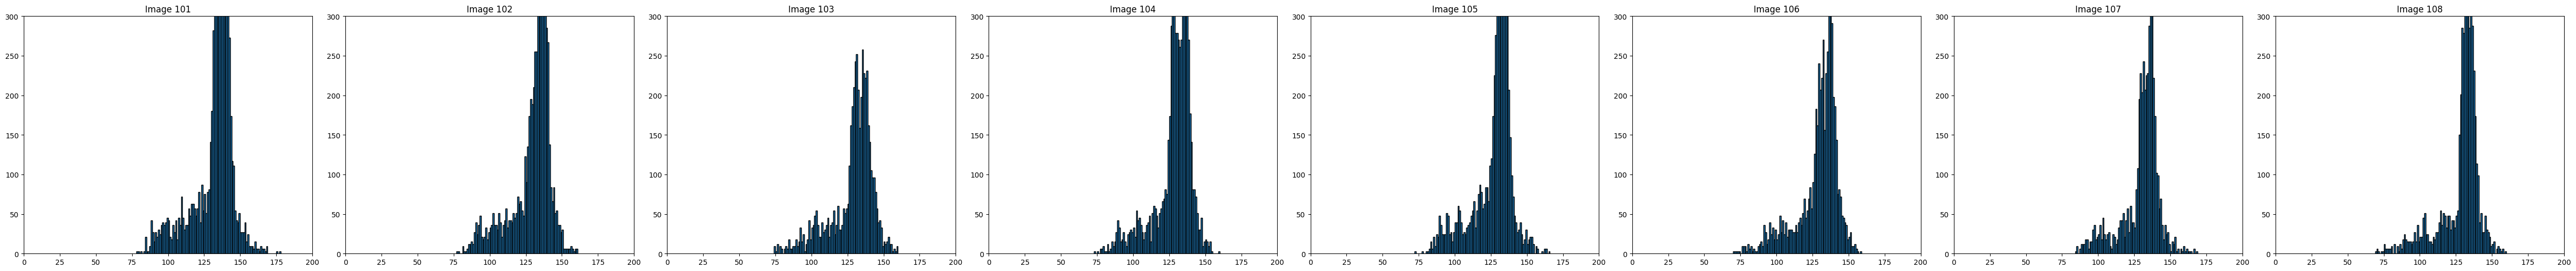

In [ ]:
plt.figure(figsize=(50, 50))
img = 100

for i in range(8):
    plt.subplot(10, 8, i+1)
    image_data = np.array(cropped_cells[i + img]).flatten()
    bins = range(min(image_data), max(image_data) + 2)
    plt.hist(image_data, bins=bins, edgecolor='black')
    plt.title(f'Image {i + img + 1}')
    plt.xlim(0, 200)
    plt.ylim(0, 300)
plt.tight_layout()
plt.show()


## DBSCAN

In [ ]:
from skimage.transform import resize

# Define the target size
target_size = (50, 50)

cropped_cells_resized = [resize(image, target_size, mode='reflect') for image in cropped_cells]
print(f"Resized Image to shape: {np.array(cropped_cells_resized).shape}")

image_vectors = np.array([np.array(image).flatten() for image in cropped_cells_resized])


Resized Image to shape: (1414, 50, 50, 3)


<ipython-input-14-c55290e65dac>:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


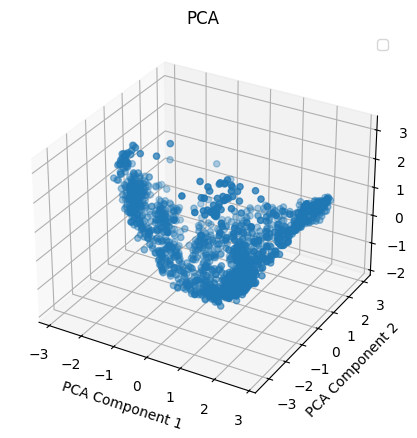

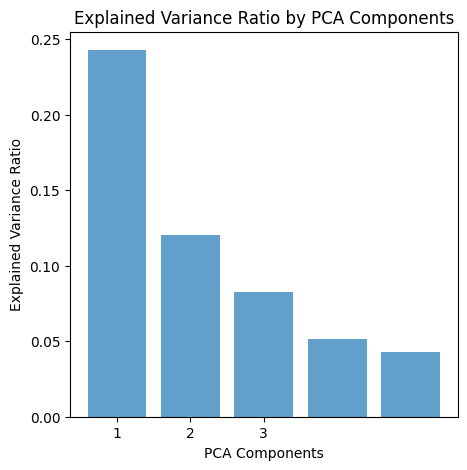

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
reduced_data = pca.fit_transform(image_vectors)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2])
ax.set_title("PCA")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.legend()
plt.show()

explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(5, 5))
plt.bar(range(1, 6), explained_variance, alpha=0.7)
plt.title("Explained Variance Ratio by PCA Components")
plt.xlabel("PCA Components")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, 4))
plt.show()


Cluster labels from DBSCAN: [-1  0  1  2  3  4  5]

Cluster -1:


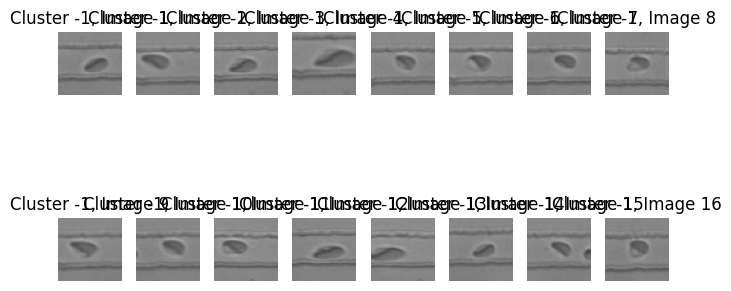


Cluster 0:


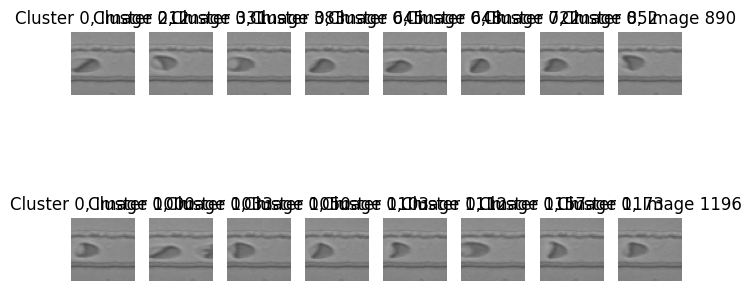


Cluster 1:


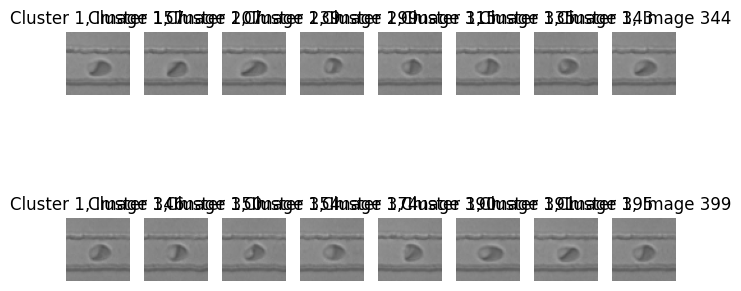


Cluster 2:


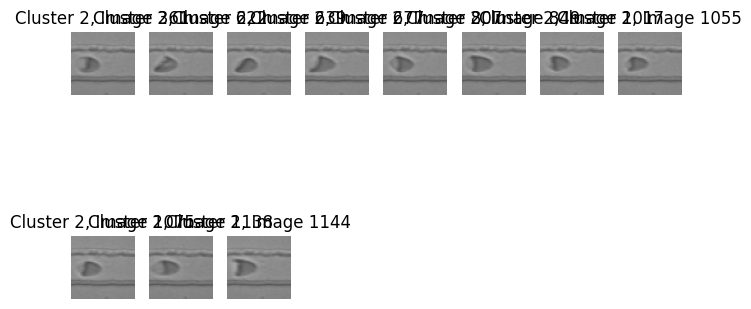


Cluster 3:


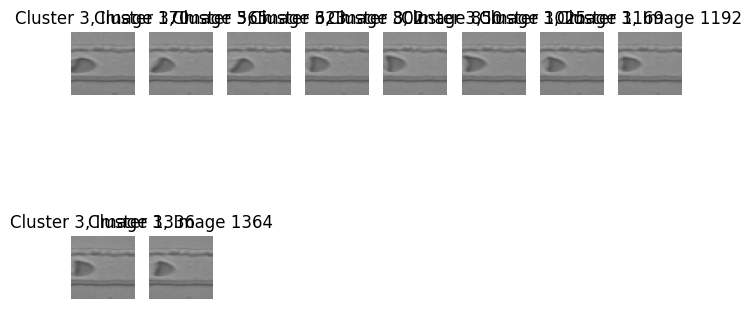


Cluster 4:


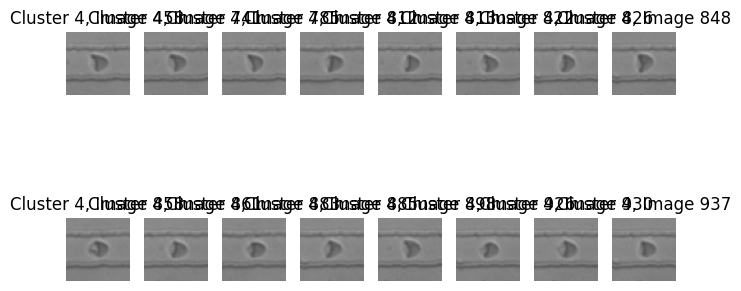


Cluster 5:


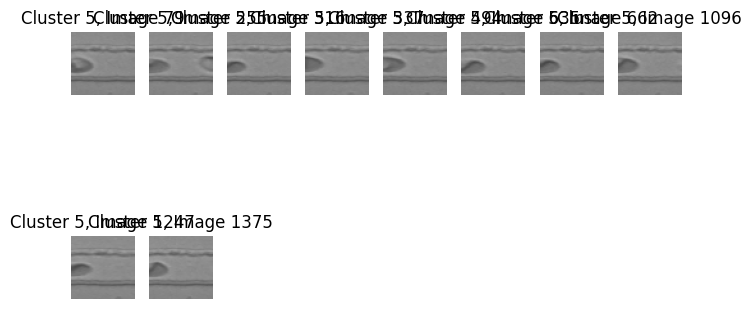

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.3, min_samples=10)
labels_dbscan = dbscan.fit_predict(reduced_data)

print(f"Cluster labels from DBSCAN: {np.unique(labels_dbscan)}")

unique_labels = np.unique(labels_dbscan)
for cluster in unique_labels:
    print(f"\nCluster {cluster}:")
    cluster_indices = np.where(labels_dbscan == cluster)[0]

    plt.figure()
    i = 1
    for idx in cluster_indices[:16]:
        plt.subplot(2, 8, i)
        plt.imshow(cropped_cells_resized[idx])
        plt.title(f"Cluster {cluster}, Image {idx + 1}")
        plt.axis('off')
        i += 1
    plt.tight_layout()
    plt.show()


In [ ]:
unique_labels, counts = np.unique(labels_dbscan, return_counts=True)

print("Numero di immagini per cluster:")
for label, count in zip(unique_labels, counts):
    if label == -1:
        print(f"Cluster {label} (rumore): {count} immagini")
    else:
        print(f"Cluster {label}: {count} immagini")

Numero di immagini per cluster:
Cluster -1 (rumore): 1221 immagini
Cluster 0: 19 immagini
Cluster 1: 100 immagini
Cluster 2: 11 immagini
Cluster 3: 10 immagini
Cluster 4: 43 immagini
Cluster 5: 10 immagini


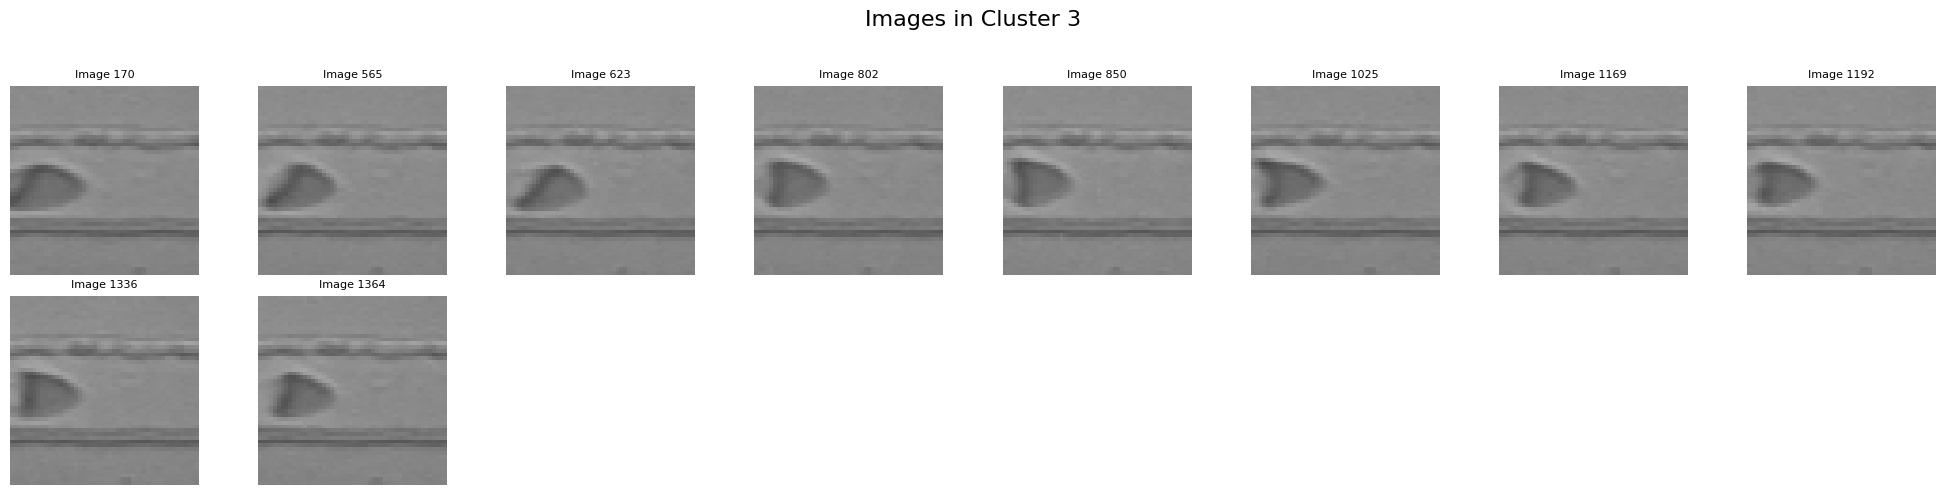

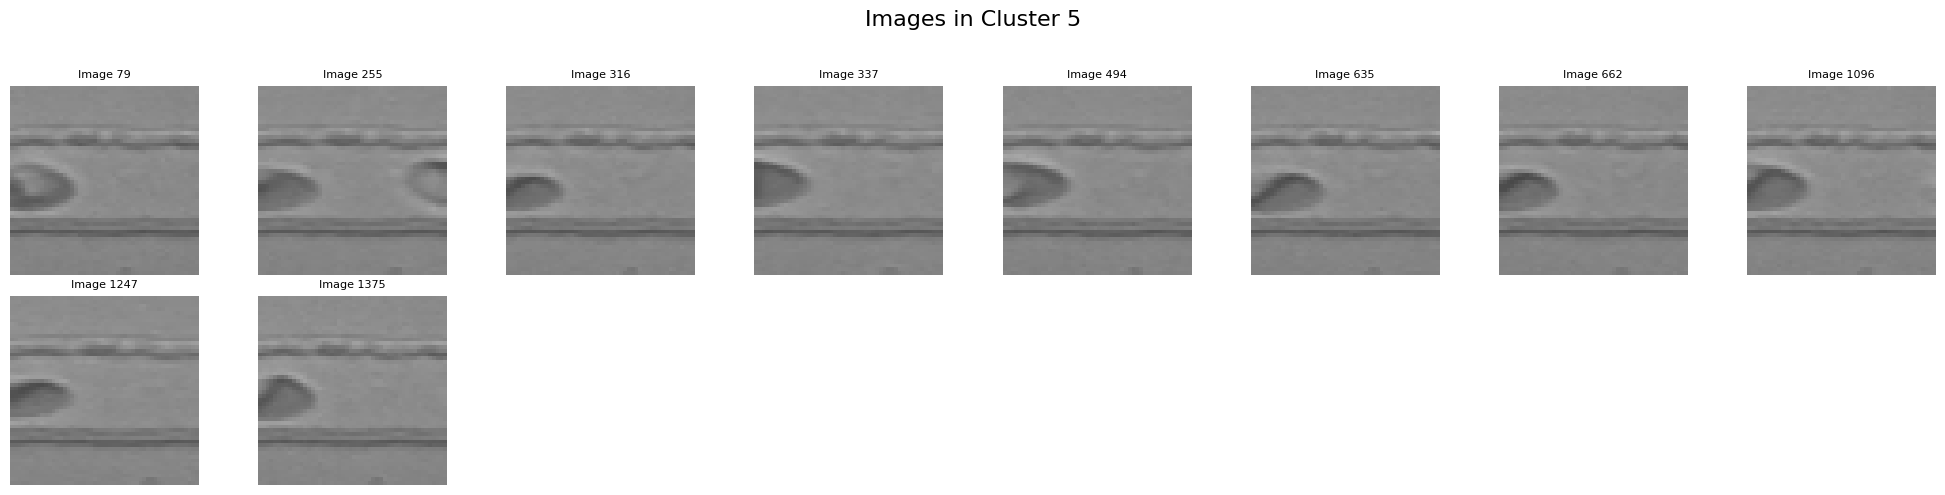

In [ ]:
clusters_to_plot = [3,5]

for cluster in clusters_to_plot:
    cluster_indices = np.where(labels_dbscan == cluster)[0]
    n_images = len(cluster_indices)

    n_cols = 8
    n_rows = (n_images + n_cols - 1) // n_cols

    plt.figure(figsize=(20, n_rows * 2.5))

    for i, idx in enumerate(cluster_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(cropped_cells_resized[idx])
        plt.title(f"Image {idx + 1}", fontsize=8)
        plt.axis('off')

    plt.suptitle(f"Images in Cluster {cluster}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Save images

In [ ]:
# Filter the cells you want to save
clusters = [-1, 0, 1, 2, 4]

selected_cells = []
selected_cell_metadata = []
y_label = []
for cluster in clusters:
    cluster_indices = np.where(labels_dbscan == cluster)[0]
    for idx in cluster_indices:
        selected_cells.append(cropped_cells_resized[idx])
        selected_cell_metadata.append(cell_metadata[idx])
        y_label.append(cell_metadata[idx]['cell_idx'])

In [ ]:
save_images_by_category(
    selected_cells,
    y_label,
    output_dir="Final_dataset_2024",
    categories=categories_2024_study
)

Saved 1394 images in Final_dataset_2025


In [ ]:
# After saving the cells
report_folder_distribution(output_dir="Final_dataset_2024")


Distribution of images in each folder:
Slipper: 248 images
semi-Slipper: 179 images
semi-Parachute: 285 images
Parachute: 682 images
